In [7]:
from pathlib import Path
import random
from pdf_to_imgs_node import PdfToImagesNode
from step_panel_detector_node import DetectStepPanelsNode
from yolo_step_panel_detector import StepPanelDetector
from crop_step_panel_node import CropStepPanelsNode
from helpers import visualize_detections

In [2]:
pdf_path = r"C:\Users\Kenan\Desktop\IKEA_Project\IKEA_assembly_guide_assistent\pdfs\ikea2.pdf"
artifacts_root = Path(r"C:\Users\Kenan\Desktop\IKEA_Project\IKEA_assembly_guide_assistent\artifacts_test")
weights = r"C:\Windows\System32\runs\detect\train\weights\best.pt"


In [3]:
# 1) pdf -> pages
pdf_node = PdfToImagesNode(artifact_root=artifacts_root, dpi=200)
state = {
    "pdf_source": {"kind": "path", "path": pdf_path, "filename": Path(pdf_path).name}
}
out1 = pdf_node(state)
state.update(out1)  # mimic LangGraph merge



In [4]:
# 2) detect panels
detector = StepPanelDetector(weights_path=weights, conf=0.20, iou=0.7, device="cuda:0")
detect_node = DetectStepPanelsNode(detector)

out2 = detect_node(state)
state.update(out2)



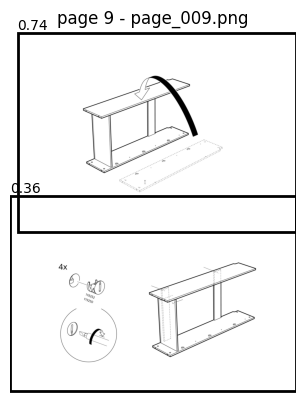

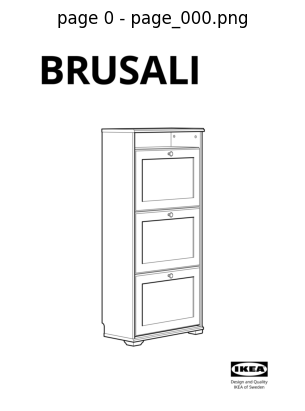

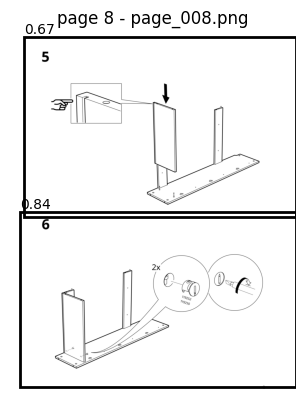

In [5]:
# 3) visualize a few random pages
pages = state["pdf_render"]["pages"]
available = [p for p in pages if "image_path" in p]
sample_pages = random.sample(available, k=min(3, len(available)))

det_by_page = state["panel_detections"]["by_page"]

for p in sample_pages:
    idx = p["page_index"]
    img_path = p["image_path"]
    dets = det_by_page.get(idx, [])
    visualize_detections(img_path, dets, title=f"page {idx} - {Path(img_path).name}")

In [6]:
state

{'pdf_source': {'kind': 'path',
  'path': 'C:\\Users\\Kenan\\Desktop\\IKEA_Project\\IKEA_assembly_guide_assistent\\pdfs\\ikea2.pdf',
  'filename': 'ikea2.pdf'},
 'pdf_render': {'cache_key': '079e27e44a249c67f54f480c46cc5773dd39546eb27f0b493cfd7a4ffc149e03_dpi200_png_pymupdf_v1',
  'pdf_hash': '079e27e44a249c67f54f480c46cc5773dd39546eb27f0b493cfd7a4ffc149e03',
  'renderer_version': 'pymupdf_v1',
  'page_count': 10,
  'dpi': 200,
  'format': 'png',
  'pages': [{'page_index': 0,
    'image_path': 'C:\\Users\\Kenan\\Desktop\\IKEA_Project\\IKEA_assembly_guide_assistent\\artifacts_test\\pdf_pages\\079e27e44a249c67f54f480c46cc5773dd39546eb27f0b493cfd7a4ffc149e03_dpi200_png_pymupdf_v1\\page_000.png',
    'width_px': 1700,
    'height_px': 2200,
    'dpi': 200},
   {'page_index': 1,
    'image_path': 'C:\\Users\\Kenan\\Desktop\\IKEA_Project\\IKEA_assembly_guide_assistent\\artifacts_test\\pdf_pages\\079e27e44a249c67f54f480c46cc5773dd39546eb27f0b493cfd7a4ffc149e03_dpi200_png_pymupdf_v1\\page_001.

In [10]:
crop_node = CropStepPanelsNode(
        artifacts_root=Path(r"C:\Users\Kenan\Desktop\IKEA_Project\IKEA_assembly_guide_assistent\artifacts_test"),
        padding_px=16,
        cache_policy="refresh",  # set to "use_cache" later
    )

out3 = crop_node(state)   # state already contains pdf_render + panel_detections
state.update(out3)

print("Cropped steps:", state["step_crops"]["step_count"])
print("First crop:", state["step_crops"]["steps"][0]["image_path"])

Cropped steps: 8
First crop: C:\Users\Kenan\Desktop\IKEA_Project\IKEA_assembly_guide_assistent\artifacts_test\step_crops\079e27e44a249c67f54f480c46cc5773dd39546eb27f0b493cfd7a4ffc149e03_dpi200_png_pymupdf_v1\step_079e27_p006_s00.png
